### 5. Model-based collaborative filtering

In [6]:
import numpy as np
import pandas as pd
ratings = pd.read_csv('ratings.csv',quotechar='"')
movies = pd.read_csv('movies.csv',quotechar='"')
import matplotlib.pyplot as plt

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise import accuracy

from surprise import NMF, SVD

from sklearn.metrics import roc_curve, auc

##### Problem 17

In [27]:
from surprise import NMF

reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)

outputs = []
for k in ks:
    algo = NMF(n_factors=int(k))
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    
avg_rmses = []
avg_maes = []
for output in outputs:
    avg_rmses.append(np.mean(output['test_rmse']))
    avg_maes.append(np.mean(output['test_mae']))

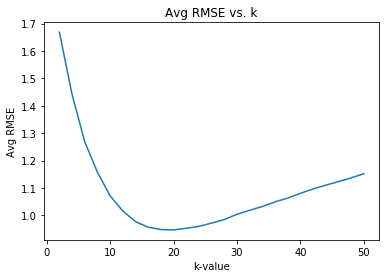

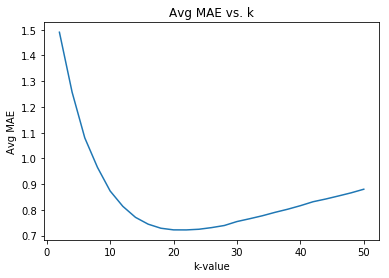

In [34]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses)
plt.show()

plt.figure()
plt.title("Avg MAE vs. k")
plt.ylabel("Avg MAE")
plt.xlabel("k-value")
plt.plot(ks, avg_maes)
plt.show()

##### Problem 18

In [92]:
import math

def euclidean_elbow(ks, curve, verbose=False):
    #get first point
    s_x, s_y = ks[0], curve[0]

    #get last point
    e_x, e_y = ks[len(ks)-1], curve[len(curve)-1]

   

    slope = (e_y-s_y)/float(e_x-s_x)
    b = s_y - slope*s_x
#    print(s_x, s_y)
#    print(e_x, e_y)
#    print(slope)
    #get midpoint
    m_idx = int((len(ks)/2)-1)
    x_mid = ks[m_idx]
    y_mid = slope*x_mid + b


    #iterate through all points along the curve
    distances = []
    for x, y in zip(ks, curve):
        #get the x and y points of the vector line
        y2 = e_y
        y1 = s_y
        x2 = e_x
        x1 = s_x
        x3 = x
        y3 = y
        
        k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / ((y2-y1)**2 + (x2-x1)**2)
        x4 = x3 - k * (y2-y1)
        y4 = y3 + k * (x2-x1) 
        #calculate distance
        distance = math.sqrt((x-x4)**2 + (y-y4)**2)
        distances.append(distance)

    #find max distance
    max_dist_index = np.argmax(distances)
    if(verbose):
        print(distances)
        print("best k: ", ks[max_dist_index])




    return max_dist_index

In [93]:
mae_idx = euclidean_elbow(ks, avg_maes)
print "Best k for MAE is index:", mae_idx,', with value ', ks[mae_idx]

rmse_idx = euclidean_elbow(ks, avg_rmses)
print "Best k for RMSE is index:", rmse_idx,', with value', ks[rmse_idx]

print "Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx]) # 16

NameError: name 'avg_maes' is not defined

##### Problem 19

In [11]:
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p19 = list()

for k in ks:
    algo = NMF(n_factors=int(k))
    rmses = list()   
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)>2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p19.append(np.mean(rmses))

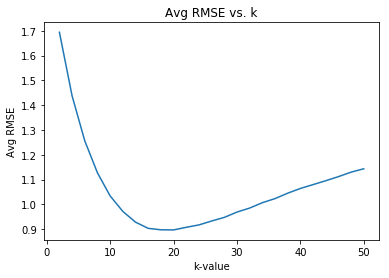

Minimum avg rmse = 0.8971


In [35]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p19)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p19))

##### Problem 20

In [4]:
from surprise import NMF
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p20= list()

for k in ks:
    algo = NMF(n_factors=int(k))
    rmses = list()   
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)<2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p20.append(np.mean(rmses))

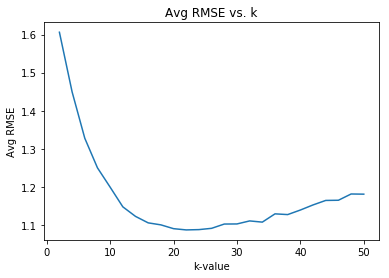

Minimum avg rmse = 1.0867


In [34]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p20)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p20))

##### Problem 21

In [6]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p21= list()

for k in ks:
    algo = NMF(n_factors=int(k))
    rmses = list()
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)>5 and np.var(x['rating'])>=2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p21.append(np.mean(rmses))

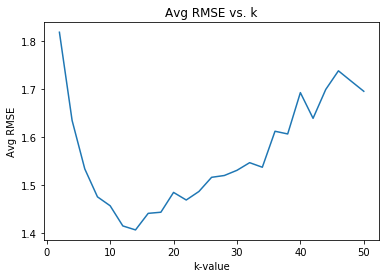

Minimum avg rmse = 1.4067


In [33]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p21)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p21))

##### Problem 22

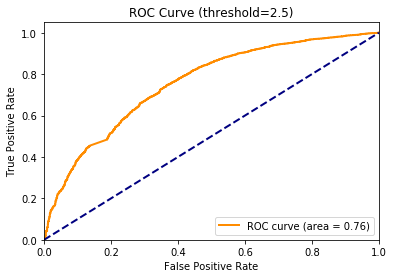

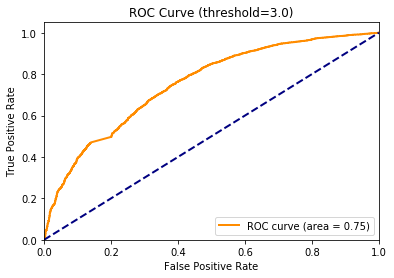

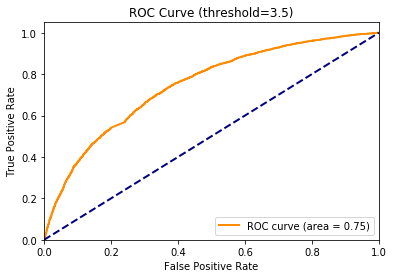

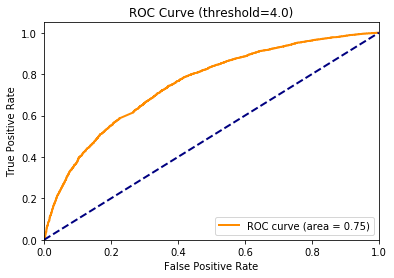

In [4]:
from sklearn.metrics import roc_curve, auc
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
trainset,testset = train_test_split(data,test_size=0.1)
algo = NMF(n_factors=16)
algo.fit(trainset)
prediction = algo.test(testset)
for threshold in [2.5,3,3.5,4]:
    true = list()
    predict = list()
    for uid, mid, actual, est, misc in prediction:
        if actual >= threshold:
            true.append(1)
        else:
            true.append(0)
        predict.append(est)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(true, predict)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (threshold=%.1f)' % threshold)
    plt.legend(loc="lower right")
    plt.show()

##### Problem 23

In [73]:
reader = Reader(line_format = 'user item rating timestamp', sep = ',', skip_lines = 1)
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

trainset= data.build_full_trainset()
algo = NMF(n_factors=20,random_state=0)

algo.fit(trainset)
V = algo.qi
print(V.shape)
V_t = np.transpose(V)
movie_index = []
movie = []
b = []

a = np.argsort(V_t[2])
c = np.array(a[:10])
for j in c:
        movie_index.append(trainset.to_raw_iid(j))

print(movie_index)    

import csv
a = []
b = []
c = []
f = open('/Users/WILLLEE/Desktop/Winter18/EE219/Projects/movies.csv')
spamreader = csv.reader(f)

for row in spamreader:
    a.append(row[0])
    b.append(row[1])   
    c.append(row[2])
f.close()
movies = []
a.pop(0)
b.pop(0)
c.pop(0)
a = list(map(int, a))

index_list_0 = []
newlist = enumerate(a)
for index, item in newlist:
    for movie_id in movie_index:
        if item == movie_id:
            index_list_0.append(index)

genre = []
for i in index_list_0:
    genre.append(c[i])
print(genre)


(9066, 20)
[6219, 4143, 4603, 2887, 6450, 5106, 6797, 33817, 6686, 4520]
['Action|Comedy', 'Horror|Mystery', 'Comedy', 'Comedy|Romance', 'Comedy|Musical|Romance', 'Action|Drama|Thriller', 'Drama|War', 'Action|Comedy|Crime|Fantasy', 'Crime|Drama', 'Drama|Romance']


##### Problem 24

In [38]:
from surprise import SVD

reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)

outputs = []
for k in ks:
    algo = SVD(n_factors=int(k),biased = True)
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    
avg_rmses_p24 = []
avg_maes_p24 = []
for output in outputs:
    avg_rmses_p24.append(np.mean(output['test_rmse']))
    avg_maes_p24.append(np.mean(output['test_mae']))

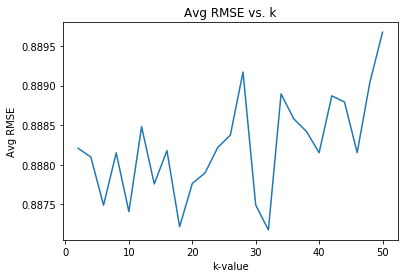

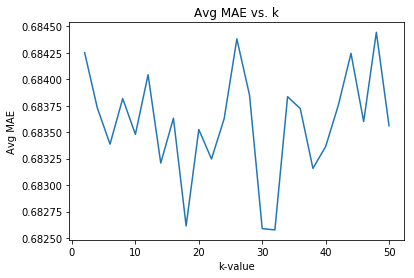

In [39]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p24)
plt.show()

plt.figure()
plt.title("Avg MAE vs. k")
plt.ylabel("Avg MAE")
plt.xlabel("k-value")
plt.plot(ks, avg_maes_p24)
plt.show()

##### Problem 25

In [40]:
mae_idx = euclidean_elbow(ks, avg_maes_p24)
print "Best k for MAE is index:", mae_idx,', with value ', ks[mae_idx]

rmse_idx = euclidean_elbow(ks, avg_rmses_p24)
print "Best k for RMSE is index:", rmse_idx,', with value', ks[rmse_idx]

print "Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx]) # 16

Best k for MAE is index: 8 , with value  18.0
Best k for RMSE is index: 15 , with value 32.0
Minimum K = 32


##### Problem 26

In [30]:
from surprise import SVD

reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p26= list()

for k in ks:
    algo = SVD(n_factors=int(k),biased = True)
    rmses = list()   
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)>2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p26.append(np.mean(rmses))

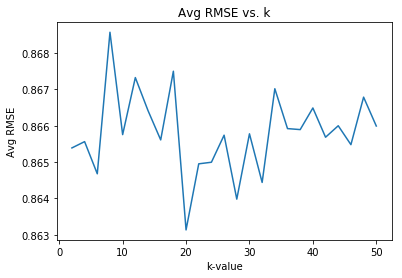

Minimum avg rmse = 0.8631


In [36]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p26)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p26))

##### Problem 27

In [ ]:
from surprise import NMF
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p27= list()

for k in ks:
    algo = NMF(n_factors=int(k),biased = True)
    rmses = list()   
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)<2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p27.append(np.mean(rmses))

In [ ]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p27)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p27))

##### Problem 28

In [ ]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avg_rmses_p28= list()

for k in ks:
    algo = SVD(n_factors=int(k))
    rmses = list()
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset = pd.DataFrame(testset, columns=['userId','movieId','rating'])
        testset = testset.groupby('movieId').filter(lambda x: len(x)>5 and np.var(x['rating'])>=2)
        testset = np.array(testset).tolist()
        predictions = algo.test(testset)
        rmses.append(accuracy.rmse(predictions, verbose=False))
    avg_rmses_p28.append(np.mean(rmses))

In [ ]:
plt.figure()
plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
plt.plot(ks, avg_rmses_p28)
plt.show()
print("Minimum avg rmse = %.4f" % np.min(avg_rmses_p28))

##### Problem 29

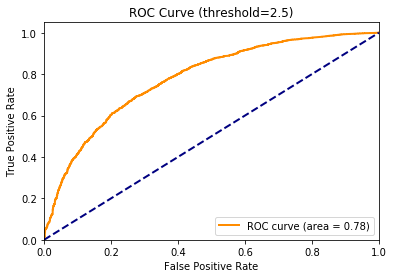

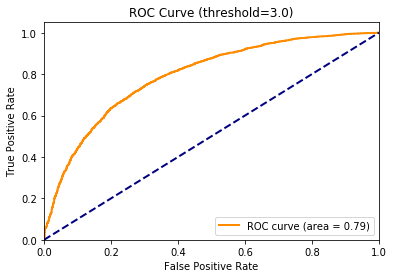

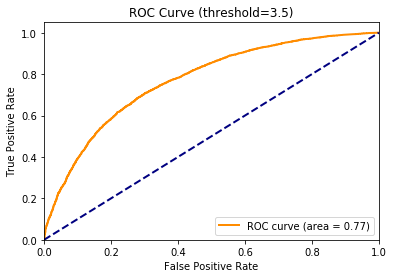

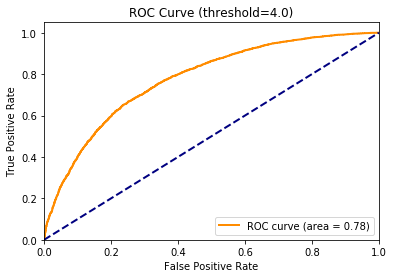

In [7]:
from sklearn.metrics import roc_curve, auc
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
trainset,testset = train_test_split(data,test_size=0.1)
algo = SVD(n_factors=36, biased = True)
algo.fit(trainset)
prediction = algo.test(testset)
for threshold in [2.5,3,3.5,4]:
    true = list()
    predict = list()
    for uid, mid, actual, est, misc in prediction:
        if actual >= threshold:
            true.append(1)
        else:
            true.append(0)
        predict.append(est)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(true, predict)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (threshold=%.1f)' % threshold)
    plt.legend(loc="lower right")
    plt.show()

### 6. Naive collaborative filtering

### 7. Performance comparison

##### Problem 34

In [8]:
sim_options = {'name': 'pearson'}
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
trainset,testset = train_test_split(data,test_size=0.1)
algo_knn = KNNWithMeans(k=16, sim_options=sim_options)
algo_knn.fit(trainset)
prediction_knn = algo_knn.test(testset)
threshold = 3
true_knn = list()
predict_knn = list()
for uid, mid, actual, est, misc in prediction_knn:
    if actual >= threshold:
        true_knn.append(1)
    else:
        true_knn.append(0)
    predict_knn.append(est)
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
fpr_knn, tpr_knn, thresholds_knn = roc_curve(true_knn, predict_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [9]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
trainset,testset = train_test_split(data,test_size=0.1)
algo_nmf = NMF(n_factors=16)
algo_nmf.fit(trainset)
prediction_nmf = algo_nmf.test(testset)
threshold = 3
true_nmf = list()
predict_nmf = list()
for uid, mid, actual, est, misc in prediction_nmf:
    if actual >= threshold:
        true_nmf.append(1)
    else:
        true_nmf.append(0)
    predict_nmf.append(est)
fpr_nmf = dict()
tpr_nmf = dict()
roc_auc_nmf = dict()
fpr_nmf, tpr_nmf, thresholds_nmf = roc_curve(true_nmf, predict_nmf)
roc_auc_nmf = auc(fpr_nmf, tpr_nmf)


In [10]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
trainset,testset = train_test_split(data,test_size=0.1)
algo_svd = SVD(n_factors=16)
algo_svd.fit(trainset)
prediction_svd = algo_svd.test(testset)
threshold = 3
true_svd = list()
predict_svd = list()
for uid, mid, actual, est, misc in prediction_svd:
    if actual >= threshold:
        true_svd.append(1)
    else:
        true_svd.append(0)
    predict_svd.append(est)
fpr_svd = dict()
tpr_svd = dict()
roc_auc_svd = dict()
fpr_svd, tpr_svd, thresholds_svd = roc_curve(true_svd, predict_svd)
roc_auc_svd= auc(fpr_svd, tpr_svd)

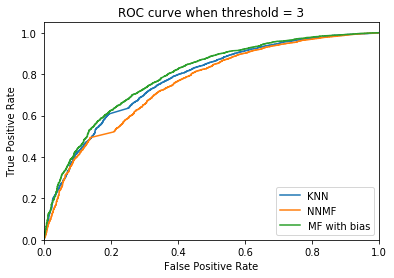

In [11]:
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot(fpr_nmf, tpr_nmf, label='NNMF')
plt.plot(fpr_svd, tpr_svd, label='MF with bias')
plt.legend(loc="lower right")
plt.title('ROC curve when threshold = 3')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()